<a href="https://colab.research.google.com/github/DankMemes4President/mnist_digit_classification/blob/main/MNIST_Digit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Performing necessary imports

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, losses, optimizers

In [ ]:
%matplotlib inline



---



Defining a separate data loading class to modularize data loading

In [ ]:
class MNISTDataLoader:
  def __init__(self, flatten=False):
    self.flatten = flatten
    self.x_train, self.y_train, self.x_val, self.y_val, self.x_test, self.y_test, self.x_train_ondevice, self.y_train_ondevice = self.load_dataset()

  def load_dataset(self):
    # load dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    #normalize images
    x_train = x_train.astype(float)/255.
    x_test = x_test.astype(float)/255.

    # reserving the last 10k images for validation
    x_train, x_val = x_train[:-10000], x_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # keep 1000 extra for on device training testing
    x_train, x_train_ondevice = x_train[:-5000], x_train[-5000:]
    y_train, y_train_ondevice = y_train[:-5000], y_train[-5000:]

    if self.flatten:
      x_train = x_train.reshape([x_train.shape[0], -1])
      x_val = x_val.reshape([x_val.shape[0], -1])
      x_test = x_test.reshape([x_test.shape[0], -1])
      x_train_ondevice = x_train_ondevice.reshape([x_train_ondevice.shape[0], -1])
    return x_train, y_train, x_val, y_val, x_test, y_test, x_train_ondevice, y_train_ondevice

  def visualize_data(self):
    print(f"x_train [shape {self.x_train.shape}] sample patch:\n",
          self.x_train[1].reshape(28, 28)[15:20, 5:10])
    print("A closeup of a sample patch: ")

    plt.imshow(self.x_train[1].reshape(28, 28)[15:20, 5:10], cmap="Greys")
    plt.show()
    print("And the whole sample:")
    plt.imshow(self.x_train[1].reshape(28, 28), cmap="Greys")
    plt.show()

    print(f"y_train [shape {self.y_train.shape}] 10 samples:\n",self.y_train[:10])

  # getters
  def get_training_data(self):
        return self.x_train, self.y_train

  def get_validation_data(self):
        return self.x_val, self.y_val

  def get_test_data(self):
        return self.x_test, self.y_test

  def get_on_device_training_data(self):
        return self.x_train_ondevice, self.y_train_ondevice




---



Making the model class for Linear Clasifier and Model builder class

In [ ]:
class LinearClassifier(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LinearClassifier, self).__init__()
        self.flatten = layers.Flatten(input_shape=input_shape)
        self.dense1 = layers.Dense(784, activation='sigmoid')
        self.batch_norm1 = layers.BatchNormalization()
        self.dense2 = layers.Dense(256, activation='sigmoid')
        self.batch_norm2 = layers.BatchNormalization()
        self.dense3 = layers.Dense(256, activation='sigmoid')
        self.batch_norm3 = layers.BatchNormalization()
        self.dense4 = layers.Dense(num_classes)

    @tf.function(input_signature=[tf.TensorSpec(shape=(None, 784), dtype=tf.float32)])
    def call(self, inputs):
        # first we flatten the image
        x = self.flatten(inputs)
        # now we pass the vector through layers to get logits
        x = self.dense1(x)
        x = self.batch_norm1(x)
        x = self.dense2(x)
        x = self.batch_norm2(x)
        x = self.dense3(x)
        x = self.batch_norm3(x)
        return self.dense4(x)

In [ ]:
class ModelBuilder(tf.Module):
  def __init__(self, input_shape, num_classes, learning_rate=0.01):
    self.input_shape = input_shape
    self.num_classes = num_classes
    self.learning_rate=learning_rate
    self.model = self.build_model()

  def build_model(self):
    model = LinearClassifier(self.input_shape, self.num_classes)
    optimizer = tf.keras.optimizers.SGD(learning_rate=self.learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        )
    return model

  @tf.function(input_signature=[tf.TensorSpec(shape=(None, 784), dtype=tf.float64),
                              tf.TensorSpec(shape=(None,), dtype=tf.uint8)])
  def train(self, x_train, y_train):
    with tf.GradientTape() as tape:
      prediction = self.model(x_train)
      loss = self.model.loss(y_train, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    result = {"loss": loss, "output": prediction}
    return result

  @tf.function(input_signature=[tf.TensorSpec(shape=(None, 784), dtype=tf.float32),])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits)
    loss = self.model.loss(tf.argmax(probabilities, axis=1), probabilities)
    return {
        'output': probabilities,
        'logits': logits,
        'loss': loss
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors



---



Training the model

In [ ]:
# load data
data_loader = MNISTDataLoader(flatten=True)
# visualize data
# data_loader.visualize_data()

11490434/11490434 [==============================] - 0s 0us/step


Finished 10 epochs
  loss: 2.225
Finished 20 epochs
  loss: 1.350
Finished 30 epochs
  loss: 0.740
Finished 40 epochs
  loss: 0.537
Finished 50 epochs
  loss: 0.484


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


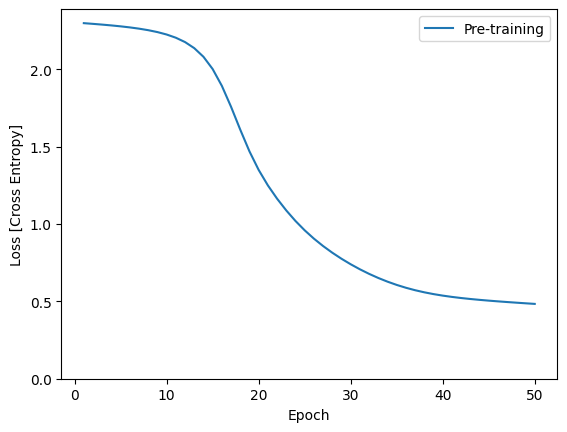

In [ ]:
# get training, validation and test data
x_train, y_train = data_loader.get_training_data()
x_val, y_val = data_loader.get_validation_data()
x_test, y_test = data_loader.get_test_data()

# build and train the model
m = ModelBuilder(input_shape=x_train.shape[1:], num_classes=10)
NUM_EPOCHS = 50
BATCH_SIZE = 128
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('./model.ckpt')

# plotting the output
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

SAVED_MODEL_DIR = "saved_model"
tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

inference_original = m.infer(x=x_test[:1])
logits_original = inference_original['logits'][0]
inference_lite = infer(x=tf.cast(x_test[:1], tf.float32))
logits_lite = inference_lite['logits'][0]

In [ ]:
def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

tf.Tensor(
[[6.7047011e-05 1.3699690e-06 2.1407739e-05 8.0976129e-04 7.3205447e-06
  2.1343393e-04 4.5865551e-09 9.9201876e-01 2.2769953e-05 6.8382281e-03]], shape=(1, 10), dtype=float32)
[[6.7046749e-05 1.3699600e-06 2.1407612e-05 8.0975849e-04 7.3205033e-06
  2.1343309e-04 4.5865018e-09 9.9201876e-01 2.2769824e-05 6.8381950e-03]]


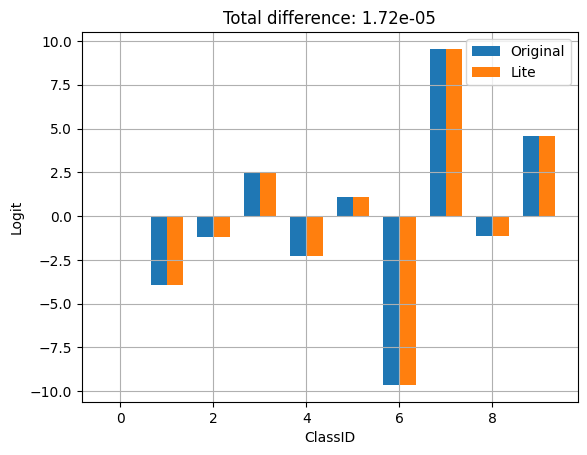

In [ ]:
compare_logits({'Original': logits_original, 'Lite': logits_lite})
print(inference_original['output'])
print(inference_lite['output'])

In [ ]:
def ondevice_train(train, x_train_on_device, y_train_on_device, batch_size, num_epochs, original_epochs, original_losses):
    epochs = np.arange(original_epochs[-1] + 1, original_epochs[-1] + num_epochs + 1, 1)
    losses = np.zeros([num_epochs])
    train_ds = tf.data.Dataset.from_tensor_slices((x_train_on_device, y_train_on_device)).batch(batch_size)

    for i in range(num_epochs):
        for x, y in train_ds:
            result = train(x_train=x, y_train=y)
        losses[i] = result['loss']
        if (i + 1) % 10 == 0:
            print(f"Finished {i + 1} epochs")
            print(f"  loss: {losses[i]:.3f}")

    plt.plot(original_epochs, original_losses, label='Pre-training')
    plt.plot(epochs, losses, label=f'On-device BS={batch_size}')
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [Cross Entropy]')
    plt.legend()
    plt.show()

    return losses

In [ ]:
data_loader = MNISTDataLoader(flatten=True)
x_train_on_device, y_train_on_device = data_loader.get_on_device_training_data()
train = interpreter.get_signature_runner("train")

NUM_EPOCHS = 30
BATCH_SIZEs = {"tc #1": 2, "tc #2":8, "tc #3": 16, "tc #4": 32, "tc #5": 64}

Batch size = 4

In [ ]:
result_tc1 = ondevice_train(train=train, x_train_on_device=x_train_on_device, y_train_on_device=y_train_on_device, batch_size=BATCH_SIZEs["tc #1"], num_epochs=NUM_EPOCHS, original_epochs=epochs, original_losses=losses)
result_tc2 = ondevice_train(train=train, x_train_on_device=x_train_on_device, y_train_on_device=y_train_on_device, batch_size=BATCH_SIZEs["tc #2"], num_epochs=NUM_EPOCHS, original_epochs=epochs, original_losses=losses)
result_tc3 = ondevice_train(train=train, x_train_on_device=x_train_on_device, y_train_on_device=y_train_on_device, batch_size=BATCH_SIZEs["tc #3"], num_epochs=NUM_EPOCHS, original_epochs=epochs, original_losses=losses)
result_tc4 = ondevice_train(train=train, x_train_on_device=x_train_on_device, y_train_on_device=y_train_on_device, batch_size=BATCH_SIZEs["tc #4"], num_epochs=NUM_EPOCHS, original_epochs=epochs, original_losses=losses)
result_tc5 = ondevice_train(train=train, x_train_on_device=x_train_on_device, y_train_on_device=y_train_on_device, batch_size=BATCH_SIZEs["tc #5"], num_epochs=NUM_EPOCHS, original_epochs=epochs, original_losses=losses)

In [ ]:
import time

def ondevice_train(train, x_train_on_device, y_train_on_device, batch_size, num_epochs, original_epochs, original_losses, x_val, y_val):
    epochs = np.arange(original_epochs[-1] + 1, original_epochs[-1] + num_epochs + 1, 1)
    losses = np.zeros([num_epochs])
    val_losses = np.zeros([num_epochs])
    train_accuracies = np.zeros([num_epochs])
    val_accuracies = np.zeros([num_epochs])
    times = np.zeros([num_epochs])
    train_ds = tf.data.Dataset.from_tensor_slices((x_train_on_device, y_train_on_device)).batch(batch_size)

    for i in range(num_epochs):
        start_time = time.time()
        train_predictions = []  # Initialize list to store predictions
        for x, y in train_ds:
            result = train(x_train=x, y_train=y)
            train_predictions.append(result['output'])
        losses[i] = result['loss']
        # Calculate validation loss and accuracy
        val_result = train(x_train=x_val, y_train=y_val)
        # print(val_result)
        val_losses[i] = val_result['loss']
        val_accuracies[i] = np.mean(np.argmax(val_result['output'], axis=1) == y_val)
        # Calculate training accuracy
        train_predictions = np.concatenate(train_predictions, axis=0)
        train_accuracies[i] = np.mean(np.argmax(train_predictions, axis=1) == y_train_on_device)
        times[i] = time.time() - start_time

        if (i + 1) % 10 == 0:
            print(f"Finished {i + 1} epochs")
            print(f"  loss: {losses[i]:.3f}, val_loss: {val_losses[i]:.3f}, train_acc: {train_accuracies[i]:.3f}, val_acc: {val_accuracies[i]:.3f}")

    plt.figure(figsize=(14, 7))

    plt.subplot(2, 2, 1)
    plt.plot(original_epochs, original_losses, label='Pre-training')
    plt.plot(epochs, losses, label=f'Training Loss BS={batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss [Cross Entropy]')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, val_losses, label=f'Validation Loss BS={batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss [Cross Entropy]')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_accuracies, label=f'Training Accuracy BS={batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_accuracies, label=f'Validation Accuracy BS={batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return losses, val_losses, train_accuracies, val_accuracies, times


Finished 10 epochs
  loss: 0.176, val_loss: 0.364, train_acc: 0.907, val_acc: 0.891
Finished 20 epochs
  loss: 0.092, val_loss: 0.357, train_acc: 0.936, val_acc: 0.900
Finished 30 epochs
  loss: 0.071, val_loss: 0.372, train_acc: 0.960, val_acc: 0.902


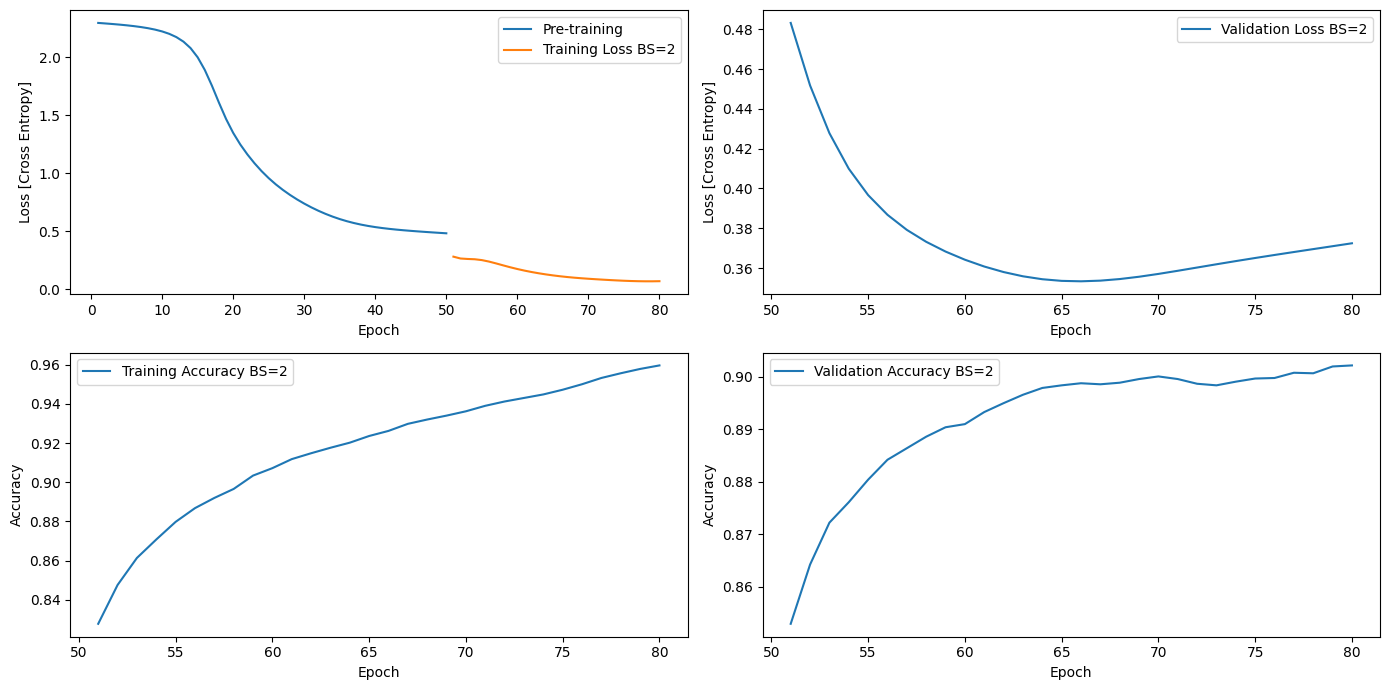

Finished tc #1
Finished 10 epochs
  loss: 0.259, val_loss: 0.404, train_acc: 0.880, val_acc: 0.879
Finished 20 epochs
  loss: 0.197, val_loss: 0.376, train_acc: 0.903, val_acc: 0.887
Finished 30 epochs
  loss: 0.153, val_loss: 0.366, train_acc: 0.916, val_acc: 0.892


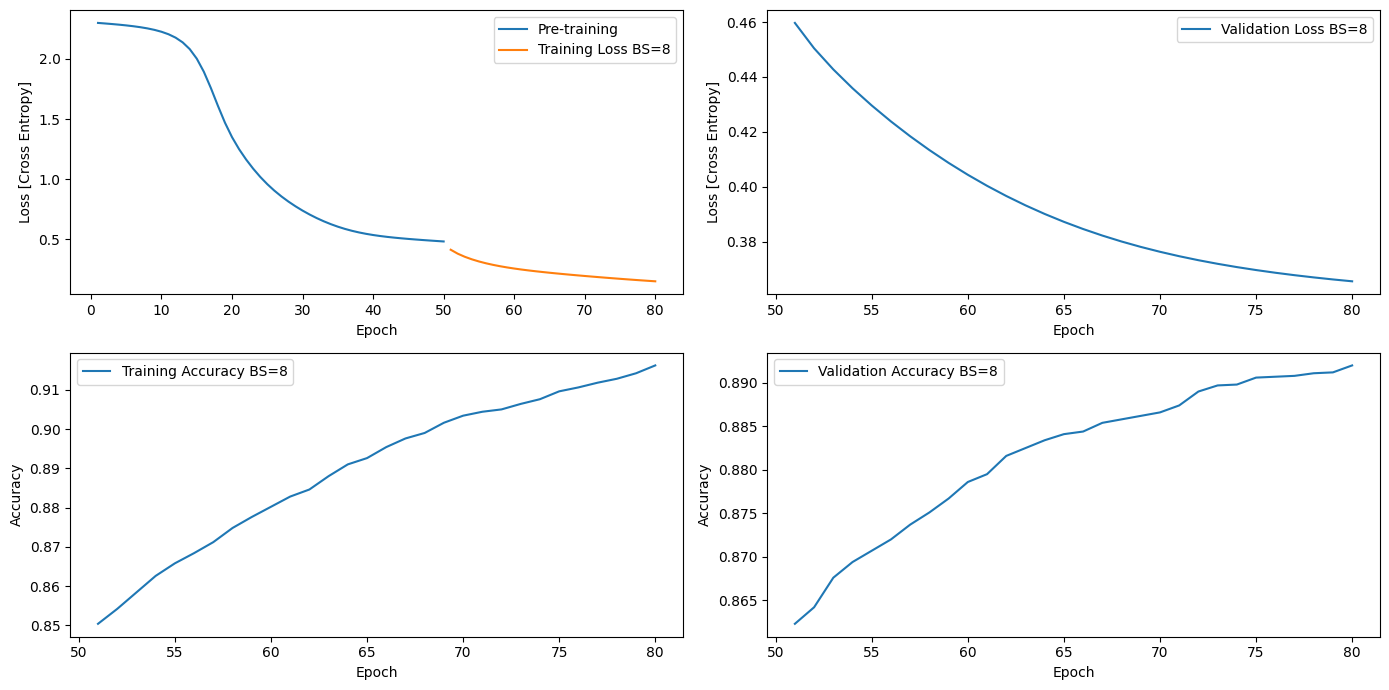

Finished tc #2
Finished 10 epochs
  loss: 0.280, val_loss: 0.415, train_acc: 0.868, val_acc: 0.878
Finished 20 epochs
  loss: 0.225, val_loss: 0.390, train_acc: 0.883, val_acc: 0.882
Finished 30 epochs
  loss: 0.189, val_loss: 0.373, train_acc: 0.894, val_acc: 0.888


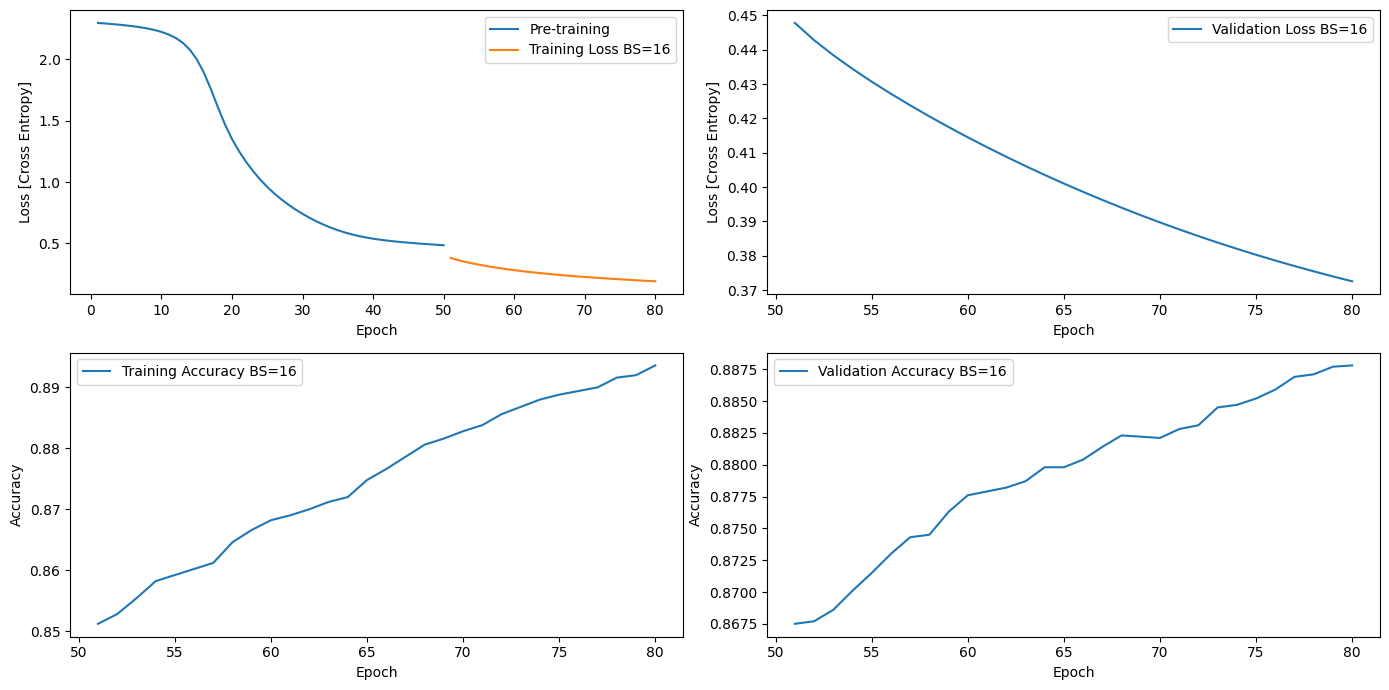

Finished tc #3
Finished 10 epochs
  loss: 0.301, val_loss: 0.420, train_acc: 0.865, val_acc: 0.876
Finished 20 epochs
  loss: 0.255, val_loss: 0.404, train_acc: 0.872, val_acc: 0.880
Finished 30 epochs
  loss: 0.222, val_loss: 0.390, train_acc: 0.879, val_acc: 0.884


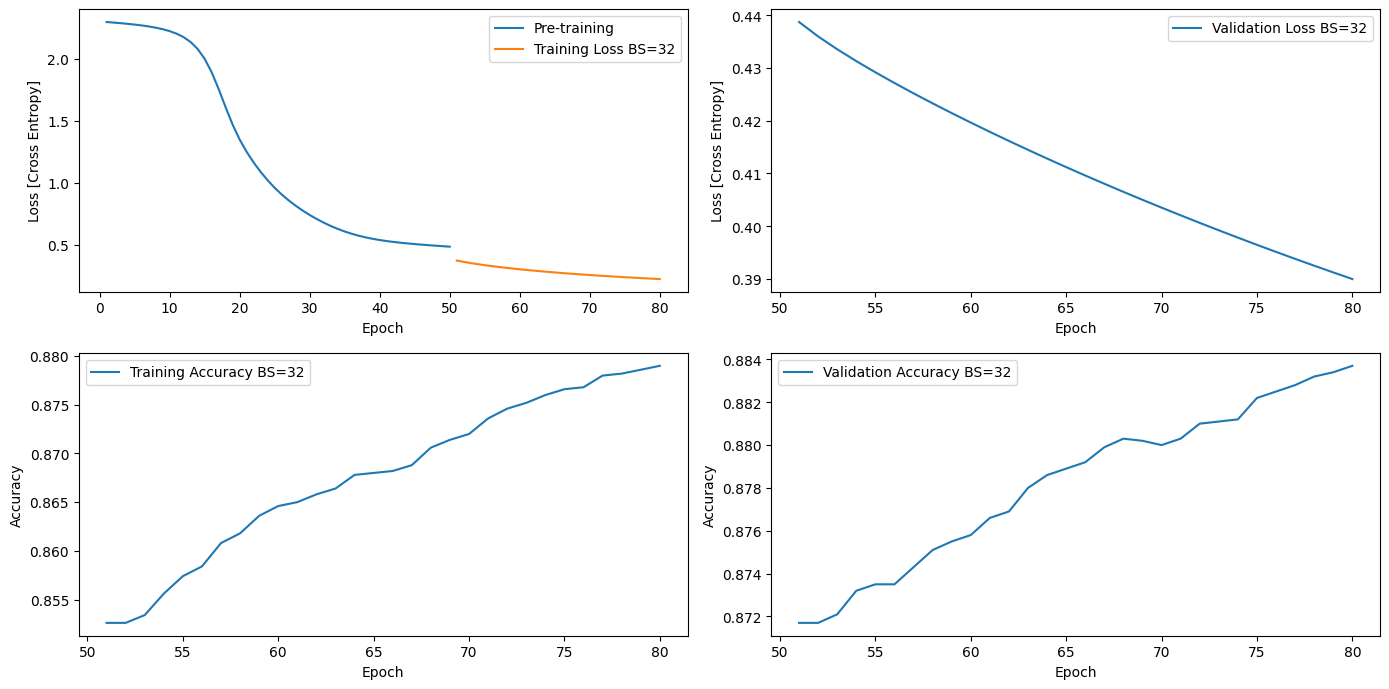

Finished tc #4
Finished 10 epochs
  loss: 0.321, val_loss: 0.424, train_acc: 0.860, val_acc: 0.876
Finished 20 epochs
  loss: 0.280, val_loss: 0.414, train_acc: 0.865, val_acc: 0.880
Finished 30 epochs
  loss: 0.251, val_loss: 0.406, train_acc: 0.870, val_acc: 0.881


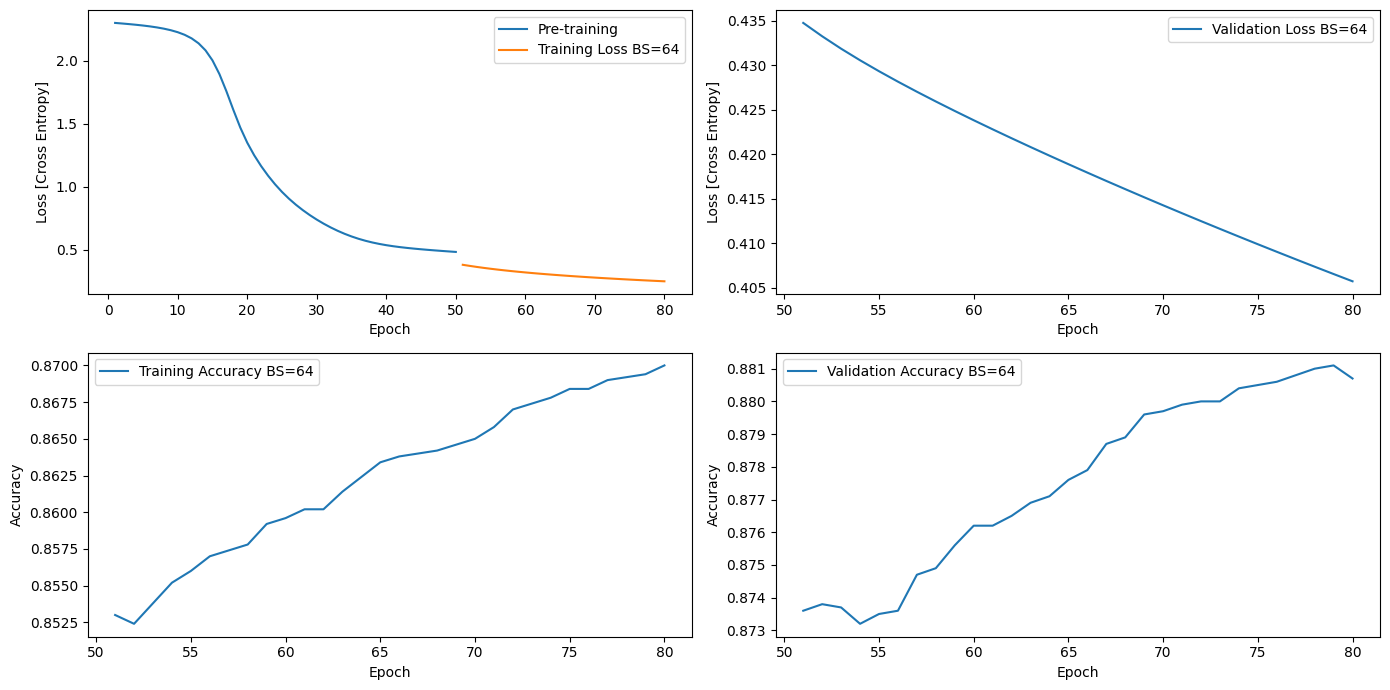

Finished tc #5


In [ ]:
restore = interpreter.get_signature_runner("restore")
save = interpreter.get_signature_runner("save")

results = {}
for tc, batch_size in BATCH_SIZEs.items():
    restore(checkpoint_path=np.array("./model.ckpt", dtype=np.string_))
    results[tc] = ondevice_train(train=train, x_train_on_device=x_train_on_device, y_train_on_device=y_train_on_device, batch_size=batch_size, num_epochs=NUM_EPOCHS, original_epochs=epochs, original_losses=losses, x_val=x_val, y_val=y_val)
    save(checkpoint_path=np.array(f"./model_bs_{batch_size}.ckpt", dtype=np.string_))
    print(f"Finished {tc}")